In [1]:
import src.get_data as get_data
import src.load_data as load
import src.compute_income as ci
import src.make_plots as MP
import src.indicators as ind


import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)

%matplotlib inline

%load_ext autoreload
%autoreload 2


sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8

In [2]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import datetime 
from pandas_datareader import data
import datetime as dt
import time 

from keras.callbacks import History 
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model, save_model
from keras import backend as K
from keras.layers.advanced_activations import LeakyReLU

import time
from sklearn import metrics

WINDOW = 22

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [3]:
def build_model(input_shape):
    
    # LSTM NN
    d = 0.2
    model = Sequential()
    
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(128, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="normal",activation='relu'))        
    model.add(Dense(1,kernel_initializer="normal",activation='linear'))
    
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    
    return model

def build_model2(input_shape):
    d = 0.2
    model = Sequential()
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(d))
    model.add(LSTM(64, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(d))
    model.add(Dense(16, kernel_initializer="uniform"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, kernel_initializer="uniform"))
    model.add(LeakyReLU(alpha=0.2))
    #adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss='mse', optimizer="rmsprop", metrics=['accuracy'])
    return model

def nextDayPrediction(typeBlockchain, stock):    
    """
    Triggers for plotting
    """
    plot = True
    plotHictory = True
    interactiveGrapth = True
    plotForTrain = False
    
    loaded = get_data.get_data_frame(typeBlockchain, stock)
    loaded.index = loaded.date

    loaded = loaded.dropna()
    
    features = ['low', 'high', 'volume', 'close']
    
    x = loaded[features].copy()
    y = loaded[['close']].copy()

    NUM_FEATURES = x.shape[1]

    scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    
    x[features] = scaler.fit_transform(x)
    
    y['close'] = y_scaler.fit_transform(y.values.reshape(-1,1))
    x[['cl_2']] = y

    X_train, y_train, X_test, y_test = load.load_data(x, WINDOW, train_size= 0.98,\
                                                      TrainTest = True)
    x = x[features] 

    model = build_model2(input_shape=(WINDOW, NUM_FEATURES))


    print('START FIT MODEL...')
    history = History()
    history= model.fit(X_train, y_train, validation_data=(X_test, y_test),  batch_size=32,\
                       epochs = 10,verbose=0,    callbacks=[history])

    today = time.strftime("_%d_%m_%Y")

    pathModel = "../../models/model_VSA" + typeBlockchain + today +".h5"

    save_model(model, pathModel)
    #model = load_model(pathModel)
    
    lastbatch = np.array(x[-WINDOW:])
    pred = model.predict([lastbatch.reshape(1,WINDOW, NUM_FEATURES)])
    pred =  np.array(y_scaler.inverse_transform(pred)) # predicted value
    
    prediction = pred.reshape(-1)
    
    print (prediction)
  
    if plot:


        prices, trainPredictPlot, testPredictPlot, testPredict, testY = MP.plot_quality_graph(\
                                                            loaded, model,\
                                                            X_train, X_test, y_train, \
                                                            y_test, y_scaler)

        calc_income = loaded.close[-y_test.shape[0]:]

    ############################ income ##############################3
        print ('income ACTUAL: ')
        print (ci.calcDOXOD(calc_income, ci.classifyALL(calc_income)    ))
        print ('income PREDICTED: ')
        print (ci.calcDOXOD(calc_income, ci.classifyALL(testPredict.reshape(-1,)))    )   
    ############################ number TRUE predicted labels for TREND #######
        print ('% TRUE predicted labels for TREND:')
        quality = np.sum([ci.classifyALL(testY.reshape(-1,)) == ci.classifyALL(testPredict.reshape(-1,))])
        print (quality/testPredict.shape[0])
       
        if interactiveGrapth:
            MP.plot_interactive(loaded, prices, trainPredictPlot, testPredictPlot)

        if plotHictory:
            MP.plotHictory(history)
        
        del model
        K.clear_session()
    return prediction

START FIT MODEL...
[ 2782.61523438]
Train Score: 78.06 RMSE
Test Score: 1057.85 RMSE


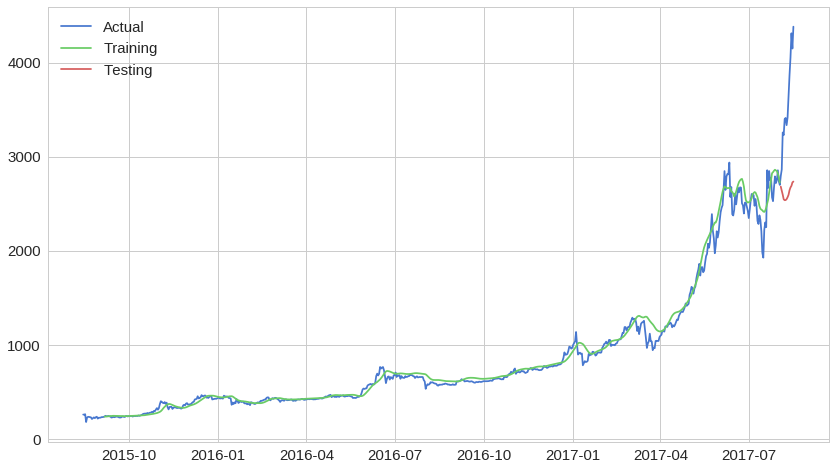

income ACTUAL: 
1852.23863735
income PREDICTED: 
1050.11999855
% TRUE predicted labels for TREND:
0.714285714286


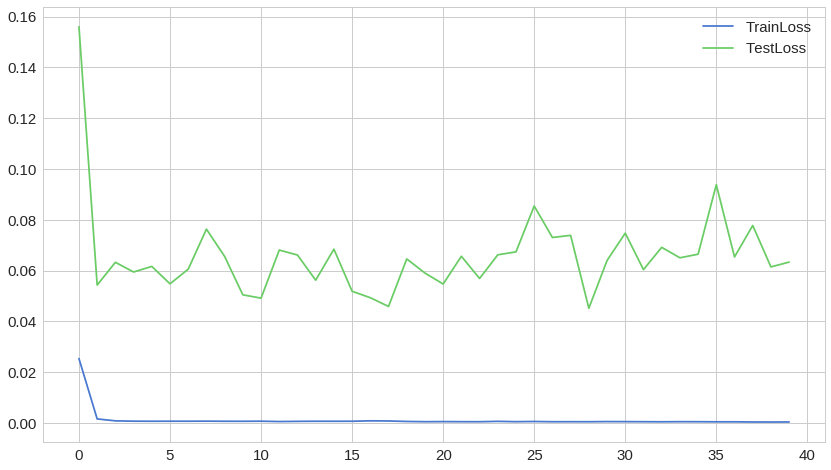

In [99]:
USD_BTC = nextDayPrediction('USDT_BTC', 'poloniex')

In [200]:
def create_model(input_shape):
    """ 
    print ('Creating model...')
    d = 0.2
    
    model = Sequential()
    model.add(LSTM(output_dim=128, input_shape=input_shape, 
                   activation='relu', inner_activation='hard_sigmoid'))    
    model.add(Dropout(d))
    model.add(Dense(128,1))
    model.add(Activation('softmax'))
    print ('Compiling...')
    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    print (model.summary())
    return model"""
    model = Sequential()
    model.add(LSTM(output_dim=128, input_shape=input_shape, 
                   activation='relu')) 
    model.add(Dense(1))
    model.add(Activation('softmax'))
    print ('Compiling...')
    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    print (model.summary())
    return model

    """
    loaded = get_data.get_data_frame(typeBlockchain, stock)
    loaded.index = loaded.date

    loaded = loaded.dropna()
    
   
   # x = loaded[['low', 'high', 'volume']].copy()
    
    ######
    # генерим признаки
    #
    dataFrame['diff_HL'] = loaded.high - loaded.low
    dataFrame['diff_H_Clos'] = loaded.high - loaded.close
    dataFrame['diff_volume'] = loaded.volume - loaded.volume.shift(1)
    
    features = ['diff_HL','diff_H_Clos', 'diff_volume']
    y = loaded[['close']].copy()

    NUM_FEATURES = x.shape[1]

    scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    
    x[features] = scaler.fit_transform(x)
    
    y['close'] = y_scaler.fit_transform(y.values.reshape(-1,1))
    x[['cl_2']] = y
"""
def trendPrediction(typeBlockchain, stock):    
    
    plot = True
    plotHictory = True
    interactiveGrapth = True
    plotForTrain = False
    
    loaded = get_data.get_data_frame(typeBlockchain, stock)
    loaded.index = loaded.date

    loaded = loaded.dropna()
    
    features = ['low', 'high', 'volume']
    
    x = loaded[features].copy()
    y = pd.DataFrame((loaded['close'] - loaded['close'].shift(1) > 0).astype('int'))

    NUM_FEATURES = x.shape[1]

    scaler = MinMaxScaler()
    
    x[features] = scaler.fit_transform(x)
    
    x[['cl_2']] = y

    X_train, y_train, X_test, y_test = load.load_data(x, WINDOW, train_size= 0.9,\
                                                      TrainTest = True)
    x = x[features] 
    print (x.head())
    model = create_model(input_shape=(WINDOW, NUM_FEATURES))


    print('START FIT MODEL...')
    history = History()
    history= model.fit(X_train, y_train, validation_data=(X_test, y_test),  batch_size=32,\
                       epochs = 300,verbose = 0,    callbacks=[history])

    today = time.strftime("_%d_%m_%Y")

    pathModel = "../../models/model_VSA_trend" + typeBlockchain + today +".h5"

    save_model(model, pathModel)
    #model = load_model(pathModel)
    
    lastbatch = np.array(x[-WINDOW:])
    pred = model.predict([lastbatch.reshape(1,WINDOW, NUM_FEATURES)])
    pred =  np.array(pred) # predicted value
    
    prediction = pred.reshape(-1)
    
    print (prediction)
    pred = model.predict(X_test)
    print (y_test)
    print (pred)
    score, acc = model.evaluate(X_test, y_test, batch_size=1)
    
    print('Test score:', score)
    print('Test accuracy:', acc)
    
    plt.plot(history.history['loss'], label = 'TrainLoss')
    plt.plot(history.history['val_loss'], label = 'TestLoss')
    plt.legend()
    plt.show()
        
    del model
    K.clear_session()
    return prediction

                 low      high        volume
date                                        
2015-08-15  0.022084  0.011177  1.033992e-06
2015-08-16  0.021685  0.010658  1.892610e-06
2015-08-17  0.021747  0.010436  7.578457e-07
2015-08-18  0.000000  0.010079  2.545005e-05
2015-08-19  0.004414  0.005204  4.471397e-05
Compiling...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               67584     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 67,713.0
Trainable params: 67,713.0
Non-trainable params: 0.0
_________________________________________________________________
None
START FIT MODEL...


/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning:

Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(22, 3), activation="relu", units=128)`



[ 1.]
[ 0.  1.  1.  0.  1.  0.  1.  0.  0.  1.  1.  0.  1.  1.  0.  1.  0.  0.
  0.  0.  1.  1.  0.  0.  0.  1.  1.  1.  0.  0.  0.  1.  0.  0.  0.  1.
  0.  0.  0.  0.  1.  1.  0.  1.  0.  1.  0.  1.  0.  0.  1.  1.  0.  1.
  1.  0.  0.  1.  1.  1.  0.  1.  1.  0.  1.  1.  1.  1.  1.  0.  1.]
[[ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]]
71/71 [==============================] - 0s     
Test score: 7.85892210544
Test accuracy: 0.507042253521


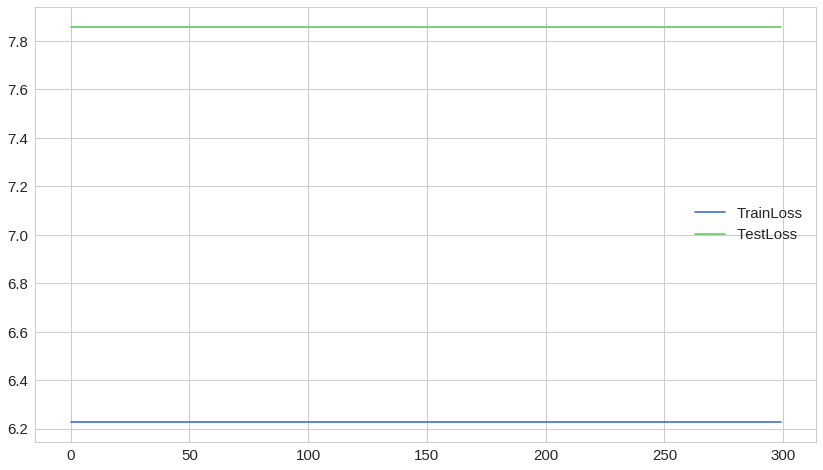

ValueError: not enough values to unpack (expected 2, got 1)

In [201]:
prediction,pred = trendPrediction('USDT_BTC', 'poloniex')

### LABEL TREND HYPOTISE

In [10]:



def nextDayPrediction(typeBlockchain, stock):    
    """
    Triggers for plotting
    """
    plot = True
    plotHictory = True
    interactiveGrapth = True
    plotForTrain = False
    
    loaded = get_data.get_data_frame(typeBlockchain, stock)
    loaded.index = loaded.date

    label_trend = pd.DataFrame((loaded['close'] - loaded['close'].shift(1) > 0).astype('int').values,\
                                            columns = ['label_trend'], index = loaded.index)

    high_low_diff= pd.DataFrame((loaded['high'] - loaded['low']).values, columns = ['high_low_diff'],
                               index = loaded.index)
    high_close_diff = pd.DataFrame((loaded['high'] \
                                    - loaded['low']).values, columns =[ 'high_close_diff'],\
                                      index = loaded.index)
    volume_shift_label = pd.DataFrame((loaded['volume'] - loaded['volume'].shift(1) > 0).astype('int').values,\
                                            columns = ['volume_shift_label'], index = loaded.index)

    volume_shift = pd.DataFrame((loaded['volume'] - loaded['volume'].shift(1)).values,\
                                            columns = ['volume_shift'], index = loaded.index)

    x = pd.concat([ label_trend,high_low_diff,\
                   high_close_diff,  volume_shift], axis = 1)
    #volume_shift_label,
    x =x.dropna()

    features = x.columns.values

    y = x.label_trend
    
    y = y.dropna()
    NUM_FEATURES = x.shape[1]

    # scale

    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    x[features] = x_scaler.fit_transform(x)
    y = y_scaler.fit_transform(y.values.reshape(-1,1))
    x['cl_f'] = y



    X_train, y_train, X_test, y_test = load.load_data(x, WINDOW, train_size= 0.9,\
                                                      TrainTest = True)
    x = x[features] 
    model = create_model(input_shape=(WINDOW, NUM_FEATURES))



    print('START FIT MODEL...')
    history = History()
    history= model.fit(X_train, y_train, validation_data=(X_test, y_test),  batch_size=32,\
                       epochs = 300,verbose = 0,    callbacks=[history])

    today = time.strftime("_%d_%m_%Y")

    pathModel = "../../models/model_VSA_01_LABEL" + typeBlockchain + today +".h5"

    save_model(model, pathModel)
    #model = load_model(pathModel)
    
    lastbatch = np.array(x[-WINDOW:])
    pred = model.predict([lastbatch.reshape(1,WINDOW, NUM_FEATURES)])
    pred =  np.array(pred) # predicted value
    
    prediction =  y_scaler.inverse_transform(pred)
    
    print (prediction)
    pred = model.predict(X_test)
    pred = y_scaler.inverse_transform(pred)
    print (y_scaler.inverse_transform(y_test))
    print (pred.reshape(-1,1))
    score, acc = model.evaluate(X_test, y_test, batch_size=1)
    
    print('Test score:', score)
    print('Test accuracy:', acc)
    
    plt.plot(history.history['loss'], label = 'TrainLoss')
    plt.plot(history.history['val_loss'], label = 'TestLoss')
    plt.legend()
    plt.show()
        
    del model
    K.clear_session()
    return prediction

/root/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning:

Data with input dtype int64 was converted to float64 by MinMaxScaler.



START FIT MODEL...
[[ 0.64561725]]
[ 1.  1.  0.  1.  0.  1.  0.  0.  1.  1.  0.  1.  1.  0.  1.  0.  0.  0.
  0.  1.  1.  0.  0.  0.  1.  1.  1.  0.  0.  0.  1.  0.  0.  0.  1.  0.
  0.  0.  0.  1.  1.  0.  1.  0.  1.  0.  1.  0.  0.  1.  1.  0.  1.  1.
  0.  0.  1.  1.  1.  0.  1.  1.  0.  1.  1.  1.  1.  1.  0.  1.  0.]
[[ 0.63590443]
 [ 0.6139909 ]
 [ 0.61381537]
 [ 0.63134855]
 [ 0.60669553]
 [ 0.63218611]
 [ 0.61518127]
 [ 0.63913935]
 [ 0.63734764]
 [ 0.62211925]
 [ 0.61617649]
 [ 0.63535863]
 [ 0.60942394]
 [ 0.60695136]
 [ 0.62837815]
 [ 0.60559982]
 [ 0.62919652]
 [ 0.62467474]
 [ 0.62977815]
 [ 0.62925833]
 [ 0.61109853]
 [ 0.60865343]
 [ 0.62927163]
 [ 0.6270172 ]
 [ 0.62667876]
 [ 0.60141265]
 [ 0.59781927]
 [ 0.59461474]
 [ 0.62238395]
 [ 0.62452024]
 [ 0.62615114]
 [ 0.60127294]
 [ 0.62340707]
 [ 0.62067962]
 [ 0.62676716]
 [ 0.60320711]
 [ 0.6263625 ]
 [ 0.62377042]
 [ 0.62726229]
 [ 0.62769389]
 [ 0.60671228]
 [ 0.60446936]
 [ 0.63043958]
 [ 0.60983652]
 [ 0.64242226]
 

/root/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.



71/71 [==============================] - 0s     
Test score: 0.260162878624
Test accuracy: 0.507042253521


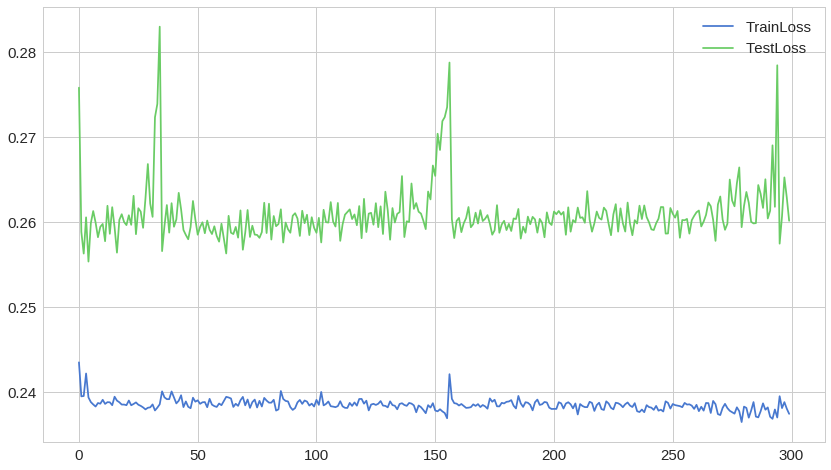

In [11]:
def create_model(input_shape):
    
    # LSTM NN
    d = 0.2
    model = Sequential()
    
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(128, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="normal",activation='relu'))        
    model.add(Dense(1,kernel_initializer="normal",activation='sigmoid'))
    
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    
    return model

pred = nextDayPrediction('USDT_BTC', 'poloniex')